In [ ]:
import requests
from groq import Groq
from typing import TypedDict, Dict, List
from langgraph.graph import StateGraph, END
from langchain_core.prompts import ChatPromptTemplate

#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

ashu = 12 

In [210]:
from langchain.chat_models import ChatOpenAI

# Initialize the GROQ LLM using OpenAI-compatible endpoint
llm = ChatOpenAI(
    base_url="https://api.groq.com/openai/v1",
    api_key="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",  # replace with your GROQ API key
    model="llama3-70b-8192",      # or another supported model like mixtral
)

In [211]:
from typing_extensions import TypedDict

class State(TypedDict):
    user_problem: str
    specialist_agent: str
    specialist_response: str
    response: str

In [212]:
from langgraph.graph import StateGraph,START,END

workflow = StateGraph(State)

In [ ]:
# Problem Classification
def problem_classification(state: State) -> State:
    print("\n problem classification agent : ")
    prompt = ChatPromptTemplate.from_template(
        "You are an AI support agent. Your task is to analyze the user's query and determine which department it should be routed to. Based on the content of the query, return one of the following categories:"

        "'billing' — for issues related to payments, invoices, charges, or refunds."
        "'tech' — for issues related to account access, login problems, bugs, or technical difficulties."
        "'shipping' — for issues related to order tracking, delivery, or shipment status. "
        "Respond with either 'billing' or 'tech' or 'shipping'"
        "User_problem : {user_problem}"
    )
    chain = prompt | llm
    Specialist_required = chain.invoke({"user_problem": state["user_problem"]}).content
    print(f"Specialist : {Specialist_required}")
    return {"specialist_agent" : Specialist_required}

# billing agent
def billing_agent(state: State) -> State:
    print("\n billing agent : ")
    prompt = ChatPromptTemplate.from_template(
        """      
        - Understand the user's concern based on their message and any provided context.
        - Identify if the issue is related to charges, refunds, invoices, subscriptions, or payment methods.
        - Simulate a helpful and professional response to resolve the issue.
        - If the issue cannot be resolved automatically, suggest the next best step (e.g., contact support or escalate).
        """
        """
        - When responding:
            Be clear and concise.
            Maintain a polite and professional tone.
            Include relevant details if available (e.g., refund timelines, invoice numbers, etc.).
        """
        "User_problem : {user_problem}"
    )
    chain = prompt | llm
    specialist_response = chain.invoke({"user_problem": state["user_problem"]}).content
    print(f"specialist_response : {specialist_response}")
    return {"specialist_response" : specialist_response}


# tech agent
def tech_agent(state: State) -> State:
    print("\n tech agent : ")
    prompt = ChatPromptTemplate.from_template(
        """      
        A)  You are a customer support agent specializing in technical issues. The user's query has already been classified as related to technical support.
        B)  Your task is to:
            -  Understand the user's problem based on their message and any provided context.
            -  Identify if the issue involves login problems, account access, errors, bugs, system crashes, or other technical difficulties.
            -  Simulate a helpful and professional response that guides the user toward resolving the issue.
            -  If the issue cannot be resolved automatically, suggest the next best step (e.g., clear instructions for troubleshooting, or escalation to human support).
        """
        """
        C)  When responding:
                - Be clear, specific, and actionable.
                - Maintain a polite and empathetic tone.
                - Use plain language that non-technical users can understand.
        """
        "User_problem : {user_problem}"
    )
    chain = prompt | llm
    specialist_response = chain.invoke({"user_problem": state["user_problem"]}).content
    print(f"specialist_response : {specialist_response}")
    return {"specialist_response" : specialist_response}


# shipping agent
def shipping_agent(state: State) -> State:
    print("\n shipping agent : ")
    prompt = ChatPromptTemplate.from_template(
        """      
        A) You are a customer support agent specializing in shipping and delivery-related issues. The user's query has already been categorized as related to shipping.
        B) Your task is to:
            - Understand the user's concern based on their message and any provided context.
            - Identify if the issue involves order tracking, delayed delivery, shipment status, address updates, or missing packages.
            - Simulate a helpful and professional response that provides the latest information or suggests next steps.
            - If the issue cannot be resolved automatically, direct the user to the appropriate escalation or support channel.
        """
        """
        C)  When responding:
            - Be clear, polite, and reassuring.
            - Include tracking information or estimated delivery times if available.
            - Offer next steps when needed (e.g., “We’ve contacted the courier…” or “You can update your address using…”).
                """
        "User_problem : {user_problem}"
    )
    chain = prompt | llm
    specialist_response = chain.invoke({"user_problem": state["user_problem"]}).content
    print(f"specialist_response : {specialist_response}")
    return {"specialist_response" : specialist_response}


def summary_agent(state:State) ->State:
    prompt = ChatPromptTemplate.from_template(
    """
    A) You are a summary Agent responsible for summarizing the outcome of a support conversation and presenting it clearly to the user.
    B) You will receive:
        - The original user query.
        - The structured response from a specialist agent (Billing, Tech, or Shipping), including a summary message and status.

    C) Your task is to:
        - Review the original query and the summary provided.

    D) while giving summary take care of below points :
        - Clearly communicates the outcome.
        - Maintains a helpful and empathetic tone.
        - Offers next steps or contact options if the issue is unresolved.
        - Use plain language. Avoid jargon. Your goal is to leave the user feeling informed and supported.
    """
    "specialist_response : {specialist_response}")
  
    chain = prompt | llm
    Summarised_response = chain.invoke({"specialist_response": state["specialist_response"]}).content
    return {"response" : Summarised_response}


In [214]:
def route_agent(state:State) -> str:
    if 'billing' in state['specialist_agent'].lower():
        return 'billing_agent'
    elif 'tech' in state['specialist_agent'].lower():
        return 'tech_agent'
    elif 'shipping' in state['specialist_agent'].lower():
        return 'shipping_agent'
    else:
        return "something wrong"
    
    


In [215]:
workflow.add_node('problem_classification',problem_classification)
workflow.add_node('billing_agent',billing_agent)
workflow.add_node('tech_agent',tech_agent)
workflow.add_node('shipping_agent',shipping_agent)
workflow.add_node('summary_agent',summary_agent)

In [216]:
workflow.set_entry_point("problem_classification")

In [217]:
#workflow.add_edge('problem_classification',route_agent)
workflow.add_edge('billing_agent', 'summary_agent')
workflow.add_edge('tech_agent', 'summary_agent')
workflow.add_edge('shipping_agent', 'summary_agent')
workflow.add_conditional_edges(
    'problem_classification',
    route_agent,
    {
        "billing_agent": "billing_agent",
        "tech_agent": "tech_agent",
        "shipping_agent": "shipping_agent"
    }
)

In [218]:
app = workflow.compile()

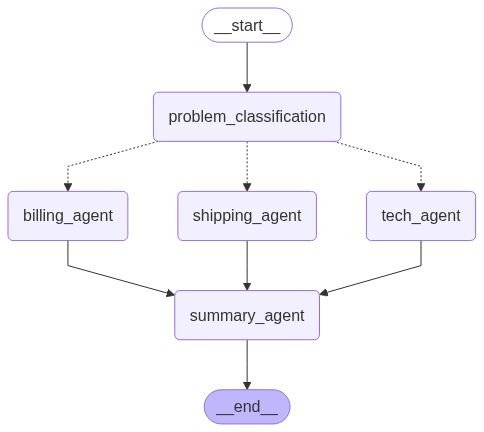

In [219]:
from IPython.display import Image, display

display(
    Image(
        app.get_graph().draw_mermaid_png()
    )

)

In [220]:


def run_candidate_screening(user_problem: str):

  results = app.invoke({"user_problem" : user_problem})
  return {
      "user_problem" : results["user_problem"],
      "specialist_agent" : results["specialist_agent"],
      "specialist_response" : results["specialist_response"],
      "response" : results["response"]
  }

In [223]:
user_problem = "i have to pay mobile amount whom i have to pay"
results = run_candidate_screening(user_problem)
print("\n\nComputed Results :")
print(f"user_problem: {user_problem}")
print(f"specialist_agent : {results['specialist_agent']}")
print(f"specialist_response: {results['specialist_response']}")
print(f"response: {results['response']}")


 problem classification agent : 
Specialist : I'd be happy to help!

Based on your query, "i have to pay mobile amount whom i have to pay", I believe this issue should be routed to the **'billing'** department, as it appears to be related to making a payment for a mobile amount.

 billing agent : 
specialist_response : I understand that you're concerned about settling a mobile bill payment. 

To clarify, you're unsure about whom to pay the mobile bill to or how to proceed with the payment. Is that correct? 

If you could provide me with more details about your mobile provider, I'll do my best to guide you through the payment process. Alternatively, you can also reach out to your mobile service provider's customer support directly for assistance.


Computed Results :
user_problem: i have to pay mobile amount whom i have to pay
specialist_agent : I'd be happy to help!

Based on your query, "i have to pay mobile amount whom i have to pay", I believe this issue should be routed to the **'